In [ ]:
options(warn = -1)

suppressWarnings({
    libs <- c("tidyverse","glmnet","caret")
load.libs <- function(x){
  for(i in x){
    if(!require(i,character.only = TRUE )){
      install.packages(i,dependencies = TRUE )
      library(i,character.only = TRUE )
    }
  }
}
load.libs(libs)
})

In [73]:
dataUnstructured<-read.table("cardio_train.csv",head=T,sep=";")

data<-dataUnstructured[,-1]%>%
    rename(Outcome=cardio)%>%
    mutate(age=round(age/362.25),
           ageSq=age**2,
           BMI=weight/((height/100)**2),
           BMISq=BMI^2)%>%
    select(-c(height,weight))%>%
    select(Outcome,everything())

trainingIndices<-data[,"Outcome"]%>%
    createDataPartition(p=0.80,list=F)

trainSet<-data[trainingIndices,]
testSet<-data[-trainingIndices,]

interactions<-c("gender","cholesterol","gluc","smoke","alco","active")
categorical<-c("gender","cholesterol","gluc","smoke","alco","active","Outcome")

designMatrix<-function(data){
    data[,names(data) %in% categorical]<-lapply(data[,names(data)%in%categorical],as.factor)
    interactionMatrix<-model.matrix(~.^2-1,data[,names(data) %in% interactions])
    additiveMatrix<-model.matrix(~.-1,data[,!names(data) %in% c(interactions,"Outcome")])
    
    return(cbind(additiveMatrix,interactionMatrix))
}

X_train<-designMatrix(trainSet)
Y_train<-as.matrix(trainSet[,"Outcome"])

X_test<-designMatrix(testSet)
Y_test<-as.matrix(testSet[,"Outcome"])

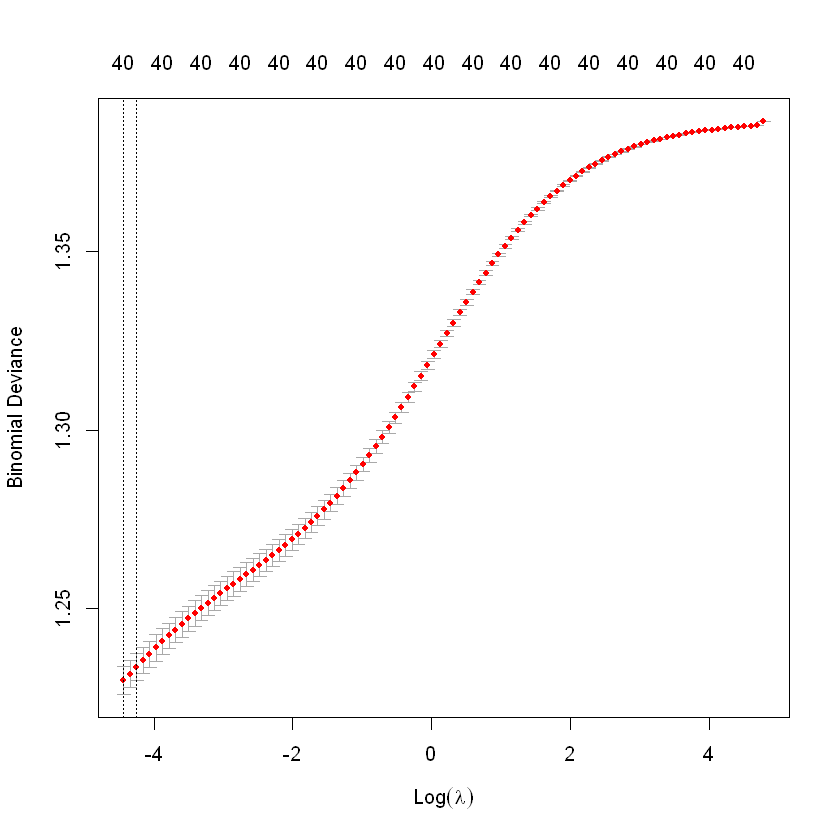

In [65]:
set.seed(50)
CV<-cv.glmnet(X_train,Y_train,
              alpha=0,nfold=10,family="binomial")
plot(CV)

In [66]:
lasso<-glmnet(X_train,Y_train,
              alpha=0,family="binomial",
              lambda=CV$lambda.min)
coef(lasso)

42 x 1 sparse Matrix of class "dgCMatrix"
                                s0
(Intercept)          -4.8865620527
age                   0.0305360720
ap_hi                 0.0066529354
ap_lo                 0.0010933389
ageSq                 0.0002789687
BMI                   0.0575197588
BMISq                -0.0001830161
(Intercept)           .           
gender2               0.1530872299
cholesterol2          0.3740072426
cholesterol3          0.8988316051
gluc2                 0.1913734750
gluc3                 0.0582884962
smoke1               -0.0126785249
alco1                -0.1157212387
active1              -0.2110600337
gender2:cholesterol2  0.2812612544
gender2:cholesterol3 -0.0178542662
gender2:gluc2         0.0886745644
gender2:gluc3        -0.2260593889
gender2:smoke1        0.0196664058
gender2:alco1         0.0418848470
gender2:active1      -0.0352022690
cholesterol2:gluc2   -0.3193186400
cholesterol3:gluc2   -0.2928878111
cholesterol2:gluc3   -0.0416990144
cholesterol3:

In [69]:
probs<-predict(lasso,X_test)
predictions<-ifelse(prob > 0.5,1,0)
trueValues<-Y_test
mean(predictions==trueValues)

[1] 0.6848571